# Fall detection using OpenCV, spatial features and RNN's

## Preprocessing

### Videos to CSV features;label

This step: 
1. Iterates over a dataset folder containing videos
2. For each set of pictures, it goes over each sequence of `SEQ_LENGTH` and loads features using OpenCV (default was set to 10 based on [this](https://www.hindawi.com/journals/wcmc/2017/9474806/) paper).
3. Once `SEQ_LENGTH` images have been seen, it saves it to a csv with the right label  
  
**The OpenCV usage**  
Following these tow papers ([paper_a](https://dl.acm.org/doi/pdf/10.1145/3197768.3201539), [paper_b](https://www.researchgate.net/publication/261424777_A_method_for_real-time_detection_of_human_fall_from_video)), I decided to run with a simple feature extraction method.  
For each picture:  
1. Remove background
2. Extract the biggest contour (assuming it is a person)
3. Fit an eclispe to the contour
4. From the eclipse, extract these features:
    * Angle
    * Top location
    * Aspect ratio
5. If this is not the first frame:
    * Change in angle
    * Change in top location (representing head speed)
    * Change in AR
    * OpticalFlow features which are not yet known to me

#### Research - how to best work with the OpenCV "gift" modules

**Notes from round 1**
It seems that the background detector is not ideal. There are too many white pixels dancing around. Let's see if I can improve it. Googling ideas gave me:
1. Erosion
2. Adding Blur before removing background, to eliminate noise.

**Notes form round 2**  
OK. Seems that both techniques really do the trick with the people. Kernel of size 4x4 was somewhat a sweetspot. I can't really say which subtractor gives nicer results, so I'll just stick to the literature standart MOG2. There clearly is a problem of "Brokem Contours", let's see how can we deal with that. [This](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5751723/pdf/sensors-17-02864.pdf) paper came to be relevant, as they faced the same issue. Moreover, it seems that they somehow cleaned the foreground image, I wonder how. It's google time!  
Ideas I found:
1. Different learning rates for the subtractor, or even stop learning after a while.
2. Dilation at the end. From OpenCV [docs](https://docs.opencv.org/trunk/d9/d61/tutorial_py_morphological_ops.html) it is called closing, so I can just try it.
3. It seems that any graph algorithm is [time expensive and won't fit](https://dsp.stackexchange.com/questions/2564/opencv-c-connect-nearby-contours-based-on-distance-between-them)

**Notes from round 3**  
Changing the learning rate didn't work. Closing worked nicely! I think there's more room for improvement, but according to the same paper mentioned in round2, a better algorithm was a very costly process, so for now let's skip it and try to go minimal. Now I want to see how will the elipses look like, and if it's really a big problem. If it is, I might have to manually combine the two biggest ones, if they are about the same size (let's say the small one is at least 20% of the big one).  
Ok, so after fitting the eclipse I can say:  
1. I must remove shadows.
2. I need to check if there is only one person there, otherwise it's going bonanza.
3. I need to connect the two biggest contours with some heuristic.

**Notes from round 4**  
Runnning the video again after the first background subtractor learned something was so much better. I will definitely let each subtractor learn on each camera. But how is this possible in production? will I have to create an object for each camera? technically yes... that's a massive amount of bg subtractors!  
Alright. For now let's try to make the most of what we have. I'll try to combine background detection with motion detection, and see if I can get better results.  
  
After I couldn't get it to work in reasonable time, I decided to skip to something else. I noticed that the ellipses change rapidly, and that's a problem. So - I think I need a method to balance the ellipses. The rule of thumb is: the more extreme the change is, the less I believe it. What makes a change extreme? the angle? the area? the center? maybe all? Let's start with mean, if the change in surface is greater than 20%.  
  
_It's definitely working!_ 😄 It's time to play with some decisions.  
Things I want to try:
1. Change to an average mean based on the ratio of growth: If the new ellipse is bigger by 80%, then it will only be considered for 20% of the change (same for smaller ellipse).
2. Only move the center but keep all the same parameters.  

**Notes from round 5**  
so, weighted average didn't work with respect to the change. This made me think I should just be more reluctant to change. After trying to just move the center it seems that ellipses change by way more than 20% each frame. It's time to try larger thresholds. There is a problem: At the beginning, the ellipse changes a lot. You know what, let's understand how much does it change actually...  
So, I tracked the area changes and tracked the angle change. It made sense to clip the change so that no sudden burst is allowed. It really improved the results! Now, it seems that the bg subtractor is just not strong enough. Since I am working with the elipse features anyways, I'm gonna try things that I didn't do before, like Ersion instead of gaussianBlur.  
  
After many trials and plays... I found something that I think is working fine. I still have to check why my `point_in_ellipse` function doesn't work, but other than that seems like the algorithm for the ellipses is pretty stable!  
  
**Notes from round 6**  
I managed to solve the `point_in_ellipse` issue, and now it seems that the system works well even without the mean ellipses! I will try on multiple videos. Another problem I solved was the min human size. I added a few more conditions to recognize a unified contour, and brought back the averaging (it is smoother with it). I think I need some system to manage "disappearing elipses", I added a 3 ellipses history. Now let's see how it works on other videos!  
Notes after watching a few other videos:
1. The `point_in_ellipse` is just a tiny bit too restrictive. It shouldn't be EXACTLY in the ellipse but rather in-or-very-close. I tried some stuff and settled on the 1.1 value
2. I almost removed the condition on contour area out of ellipse area (the min value is super low). It helped when we had some noise that merged into a huge ellipse, but the mostly happens in the beginning of the video. Since most of the videos start with some useless parts, I will have to cut them off (shouldn't be hard).  
  
Another note is that because the bg subtractor learns over time, it's better to go over the videos and not over a bunch of images each time. That means we will have to change the preprocessing stage. Luckily we already have a nice code written for us 👨‍💻

**Final notes**
All the cameras are fixed, so I can extract the background quite easily. I can create for each camera a fgbg extractor. There was something about the median frame (why median and not mean?) I should check this out. Anyways, for now I will start by runnning a generic algorithm and see how it learns.

In [1]:
import cv2
import numpy as np

In [2]:
def ellipse_area(ellipse):
    '''https://stackoverflow.com/questions/36499462/how-to-find-the-area-of-an-ellipse-obtained-using-cv-fitellipsecontour'''
    _, (MA, ma), _ = ellipse
    return np.pi * (MA / 2) * (ma / 2)

In [3]:
def min_angle_diff(old_angle, new_angle):
    '''Find the minimal difference between two angles.
    
    If we have angle X and target Y, we can either add to X until we get to Y, 
    or subtract and get to Y from the other side of the circle. When we make a
    change, we want to make it in the shortest direction. This function returns
    the *signed* smallest angle, where the sign indicates direction. 
    '''
    a = (new_angle - old_angle) % 360 - 180
    b = (new_angle + 180 - old_angle) % 360 - 180 
    return min([a,b], key=abs) 

In [4]:
AXIS_CHANGE_BOUNDARY = .1
ANGLE_CHANGE_BOUNDARY = 15

def limit_ellipse_change(old_ellipse, new_ellipse):
    '''Return the limited change of an ellipse'''
    # Unpack parameters
    old_center, old_axes, old_angle = old_ellipse
    new_center, new_axes, new_angle = new_ellipse
    old_MA, old_ma = old_axes
    new_MA, new_ma = new_axes
    # Clip changes
    MA_change = np.clip(new_MA / old_MA, 1 - AXIS_CHANGE_BOUNDARY, 1 + AXIS_CHANGE_BOUNDARY)
    ma_change = np.clip(new_ma / old_ma, 1 - AXIS_CHANGE_BOUNDARY, 1 + AXIS_CHANGE_BOUNDARY)
    angle_change = np.clip(min_angle_diff(old_angle, new_angle), -ANGLE_CHANGE_BOUNDARY, ANGLE_CHANGE_BOUNDARY)
    return np.mean([old_center, new_center], axis=0).tolist(), \
           (old_MA * MA_change, old_ma * ma_change), \
           (old_angle + angle_change) % 180

In [5]:
def get_contour_center(contour):
    m = cv2.moments(contour)
    x = m["m10"] / m["m00"]
    y = m["m01"] / m["m00"]
    return x, y

In [6]:
def check_point_ellipse_proximity(p, ellipse):
    '''This function checks whether a point is inside, or very close to an ellipse'''
    px, py = p
    (cx, cy), (MA, ma), alpha = ellipse
    a, b = MA / 2, ma / 2
    alpha = (180 - (alpha - 90)) % 180   # Convert alpha to normal axes  
    alpha = alpha * np.pi / 180.         # Convert to radians
    equ_elem_a = np.power((np.cos(alpha) * (px - cx) + np.sin(alpha) * (py - cy)) / a, 2) 
    equ_elem_b = np.power((np.sin(alpha) * (px - cx) - np.cos(alpha) * (py - cy)) / b, 2)
    return equ_elem_a + equ_elem_b <= 1.1

In [10]:
# Constants
CLOSING_KERNEL = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
EROTION_KERNEL = np.ones((2, 2), np.uint8)
MIN_HUMAN_CONTOUR_AREA = 1000
MHI_DURATION = 500 # milliseconds
MHI_THRESHOLD = 32
GAUSSIAN_KERNEL = (3, 3)

In [62]:
cap.release()
cv2.destroyAllWindows()

cap = cv2.VideoCapture('data/multicam/videos/chute14/cam7.avi')
background_subtractor = cv2.createBackgroundSubtractorMOG2()

### tMHI prep
fps = cap.get(cv2.CAP_PROP_FPS)
ms_per_frame = 1000 / fps   # milliseconds
_, last_frame = cap.read()
last_frame = cv2.GaussianBlur(last_frame, GAUSSIAN_KERNEL, 0)
h, w = last_frame.shape[:2]
mhi = np.zeros((h, w), np.float32)

### Kalman Filter Prep
state_size = 8          # [x, y, v_x, v_y, alpha, v_alpha, a, b]
measurement_size = 5    # [x, y, alpha, a, b]
kalman = cv2.KalmanFilter(state_size, measurement_size, 0)

## Transition State Matrix
# [ 1 0 dt 0  0 0  0 0 ]
# [ 0 1 0  dt 0 0  0 0 ]
# [ 0 0 1  0  0 0  0 0 ]
# [ 0 0 0  1  0 0  0 0 ]
# [ 0 0 0  0  1 dt 0 0 ]
# [ 0 0 0  0  0 1  0 0 ]
# [ 0 0 0  0  0 0  1 0 ]
# [ 0 0 0  0  0 0  0 1 ]
kalman.transitionMatrix = np.eye(state_size, dtype=np.float32)
kalman.transitionMatrix[(0,1,4), (2,3,5)] = ms_per_frame

## Measure Matrix H
# [ 1 0 0 0 0 0 0 0 ]
# [ 0 1 0 0 0 0 0 0 ]
# [ 0 0 0 0 1 0 0 0 ]
# [ 0 0 0 0 0 0 1 0 ]
# [ 0 0 0 0 0 0 0 1 ]
kalman.measurementMatrix = np.zeros((measurement_size, state_size), dtype=np.float32)
pos = [(0,0), (1,1), (2,4), (3,6), (4,7)]
rows, cols = zip(*pos)
kalman.measurementMatrix[rows, cols] = 1.

## Process Noise Covariance Matrix Q
# [ Ex  0   0     0     0    0      0   0  ]
# [ 0   Ey  0     0     0    0      0   0  ]
# [ 0   0   Ev_x  0     0    0      0   0  ]
# [ 0   0   0     Ev_y  0    0      0   0  ]
# [ 0   0   0     0     Eal  0      0   0  ]
# [ 0   0   0     0     0    Ev_al  0   0  ]
# [ 0   0   0     0     0    0      Ea  0  ]
# [ 0   0   0     0     0    0      0   Eb ]
kalman.processNoiseCov = 1e-5 * np.eye(state_size, dtype=np.float32)  # Values can't change sharply
kalman.processNoiseCov[4,4] = 0        # Angle shouldn't change very fast (unless there is a fall!)
kalman.processNoiseCov[(6,7),(6,7)] = 5e-4        # Height and width can change faster

## Measurement Noise Cov Matrix R
kalman.measurementNoiseCov = np.eye(measurement_size, dtype=np.float32)
kalman.measurementNoiseCov[2,2] = 1e-1  # Angle is very noisy (especially around the limits)
kalman.measurementNoiseCov[(0,1),(0,1)] = 1  # Center is super noisy
kalman.measurementNoiseCov[(3,4),(3,4)] = 1e-1  # Height and width are not noisy

## No contours found frame count tolerance
kalman_filter_active = False  # This will change according to our contour search
NO_CONTOUR_TOLERANCE = 10     # After this amount of frames with no contours the KF will turn inactive
contour_unfound_count = 0     

### Continous angle tracking (to avoid drastic changes on direction change)
last_angle = None

for fn in range(1, min(1200, int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))):
    ret, frame = cap.read()
    if fn < 250:
        continue

    # Set parameters to 0 unless found otherwise
    c_motion = 0
    projection_ratio = 0
                
    # Transformations to improve the background subtraction
    # tMHI
    img = cv2.GaussianBlur(frame, GAUSSIAN_KERNEL, 0)
    frame_diff = cv2.absdiff(img, last_frame)
    gray_diff = cv2.cvtColor(frame_diff, cv2.COLOR_BGR2GRAY)
    _, motion_mask = cv2.threshold(gray_diff, MHI_THRESHOLD, 1, cv2.THRESH_BINARY)
    cv2.motempl.updateMotionHistory(motion_mask, mhi, fn * ms_per_frame, MHI_DURATION)
    last_frame = img
    
    # Preparation for contour finding
    img = cv2.GaussianBlur(frame, (5,5), 0)
    img = background_subtractor.apply(img)
    img = cv2.erode(img, EROTION_KERNEL, iterations=1)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, CLOSING_KERNEL, iterations=5)
    img[img < 255] = 0

    # Find contours
    (contours, _) = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if contours:
        biggest_contour = max(contours, key=lambda c: cv2.contourArea(c))

        # Check minimal requirements to fit new ellipse
        if cv2.contourArea(biggest_contour) > MIN_HUMAN_CONTOUR_AREA and len(biggest_contour) >= 5:
            # calculate motion coefficient
            mask = np.zeros(img.shape[:2], dtype="uint8")
            cv2.drawContours(mask, biggest_contour, -1, 1, -1)
            tmhi = np.uint8(np.clip((mhi - (fn * ms_per_frame - MHI_DURATION)) / MHI_DURATION, 0, 1))
            relevant_tmhi = np.multiply(mask, tmhi)
            c_motion = np.sum(relevant_tmhi) / np.sum(mask) 

            # calculate projections
            horizontal_proj = mask.any(axis=0).sum()
            vertical_proj = mask.any(axis=1).sum()
            projection_ratio = vertical_proj / horizontal_proj

            contour_unfound_count = 0
            measured_ellipse = cv2.fitEllipse(biggest_contour)
            (x, y), (MA, ma), alpha = measured_ellipse
            cv2.ellipse(img, measured_ellipse, (0,0,255), 2)
            if not kalman_filter_active:
                last_angle = alpha
                kalman.errorCovPre = np.eye(state_size)
                state = np.array([x, y, 0, 0, alpha, 0, MA, ma], dtype=np.float32)[:, np.newaxis]
                kalman.statePost = state
                kalman_filter_active = True
            else:
                corrected_alpha = min(alpha, alpha - 180, alpha + 180, key=lambda x: abs(x - last_angle))
                kalman.correct(np.array([x, y, corrected_alpha, MA, ma], dtype=np.float32)[:, np.newaxis])
                last_angle = corrected_alpha

        else:
            contour_unfound_count += 1
            if contour_unfound_count >= NO_CONTOUR_TOLERANCE:
                kalman_filter_active = False
                last_angle = None
                
    else:
        contour_unfound_count += 1
        if contour_unfound_count >= NO_CONTOUR_TOLERANCE:
            kalman_filter_active = False
            last_angle = None
    
    if kalman_filter_active:
        state = kalman.predict() 
        x,y,_,_,alpha,_,a,b = state.T[0]
        cv2.ellipse(img, ((x, y), (a, b), alpha % 180), (255,255,0), 2)
    
    cv2.rectangle(img, (10, 2), (100,20), (255,255,255), -1)
    cv2.putText(img, str(fn), (15, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0))
    cv2.imshow('Frame', frame)
    cv2.imshow('FG Mask', img)

    keyboard = cv2.waitKey(0)
    if keyboard == ord('q') or keyboard == 27:
        break

cap.release()
cv2.destroyAllWindows()

#### Running the research results on the actual videos to produce the CSV

I decided that before I go on any further, it's time to start testing with what we already have! So now it's time for feature extraction. As planned, here are the features we will extract from the frames and their explanation:
1. Angle (ANGLE): measured between -90 and 90
2. Head location (HEAD_LOC) and speed (HEAD_SPD). This feature can prove to be very useful, for the moment we will start with the top most point in the bounding ellipse, based on [this paper](https://www.researchgate.net/publication/221551756_Robust_Fall_Detection_Using_Human_Shape_and_Multi-class_Support_Vector_Machine) and [this paper](https://homes.esat.kuleuven.be/~konijn/publications/2016/fallcam.pdf).
3. Aspect ratio (ASPECT_RATIO) and change in aspect ratio (CAR). Measured as `a / b`. 
4. Center location (CTR_LOC) and speed (CTR_SPD). Given by the ellipse `x` and `y`.

After that there will be a few more things to try:
1. Adding optical flow features and also Kalman filtering, like [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5751723/pdf/sensors-17-02864.pdf)  
  
**So without further ado, let's get to it!**

In [58]:
import csv
import json
from pathlib import Path

import cv2
import numpy as np
from tqdm.auto import tqdm, trange

In [68]:
NUM_SCENARIOS = 24
NUM_CAMERAS = 8
DATASET_FOLDER = Path('data/multicam/')
VIDEOS_FOLDER = DATASET_FOLDER / 'videos'
DATASET_CSV_FILE = DATASET_FOLDER / 'multicam_dataset.csv'
SEQ_LENGTH = 15
MIN_NUMBER_OF_FALL_FRAMES = 5  # A sequence will be classified as a fall only this number of frames into the fall and after it
FEATURES = ['CTR_LOC_X', 'CTR_LOC_Y', 'CTR_SPD_X', 'CTR_SPD_Y',
            'ANGLE', 'ANGLE_SPEED', 'WIDTH', 'HEIGHT', 
            'ASPECT_RATIO', 'C_MOTION', 'PROJ_RATIO']
# FEATURES = ['STD_ANGLE', 'STD_C_MOTION', 'STD_PROJECTION_RATIO', 'C_MOTION']

In [71]:
# Image processing constants
CLOSING_KERNEL = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
EROTION_KERNEL = np.ones((2, 2), np.uint8)
MIN_HUMAN_CONTOUR_AREA = 1000
MHI_DURATION = 500  # milliseconds
MHI_THRESHOLD = 32
GAUSSIAN_KERNEL = (3, 3)

In [72]:
with open(DATASET_FOLDER / 'annotations_multicam.json', 'r') as ano_file, open(DATASET_FOLDER / 'delays.json', 'r') as delay_file:
    annotations = json.load(ano_file)
    delays = json.load(delay_file)

In [103]:
cap.release()
csv_header = [f'{feature}_{frame}' for frame in range(SEQ_LENGTH) for feature in FEATURES] + ['LABEL']

with open(DATASET_CSV_FILE, 'a', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(csv_header)

    # Iterate over the scenarios
    for scenario in trange(1, NUM_SCENARIOS + 1, desc='scenario'):

        # Get all videos (one per camera)
        chute = f'chute{scenario:02}'
        videos = sorted(VIDEOS_FOLDER.glob(f'{chute}/*'))
        starts = annotations[f'scenario{scenario}']['start']   # All the frame indices in which a fall starts
        ends = annotations[f'scenario{scenario}']['end']       # All the frame indices in which a fall ends

        for cam, video in tqdm(enumerate(videos, 1), desc='camera', total=len(videos), leave=False):
            
            cap = cv2.VideoCapture(str(video))
            length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            delay = delays[f'{scenario}'][f'camera{cam}']
            feature_vectors_sequence = []
            background_subtractor = cv2.createBackgroundSubtractorMOG2()

            ### tMHI prep
            fps = cap.get(cv2.CAP_PROP_FPS)
            ms_per_frame = 1000 / fps   # milliseconds
            _, last_frame = cap.read()
            last_frame = cv2.GaussianBlur(last_frame, GAUSSIAN_KERNEL, 0)
            h, w = last_frame.shape[:2]
            mhi = np.zeros((h, w), np.float32)

            ### Kalman Filter Prep
            state_size = 8          # [x, y, v_x, v_y, alpha, v_alpha, a, b]
            measurement_size = 5    # [x, y, alpha, a, b]
            kalman = cv2.KalmanFilter(state_size, measurement_size, 0)
            kalman.transitionMatrix = np.eye(state_size, dtype=np.float32)
            kalman.transitionMatrix[(0,1,4), (2,3,5)] = ms_per_frame
            kalman.measurementMatrix = np.zeros((measurement_size, state_size), dtype=np.float32)
            pos = [(0,0), (1,1), (2,4), (3,6), (4,7)]
            rows, cols = zip(*pos)
            kalman.measurementMatrix[rows, cols] = 1.
            kalman.processNoiseCov = 1e-5 * np.eye(state_size, dtype=np.float32)  # Values can't change sharply
            kalman.processNoiseCov[4,4] = 0        # Angle shouldn't change very fast (unless there is a fall!)
            kalman.processNoiseCov[(6,7),(6,7)] = 5e-4        # Height and width can change faster
            kalman.measurementNoiseCov = np.eye(measurement_size, dtype=np.float32)
            kalman.measurementNoiseCov[2,2] = 1e-1  # Angle is very noisy (especially around the limits)
            kalman.measurementNoiseCov[(0,1),(0,1)] = 1  # Center is super noisy
            kalman.measurementNoiseCov[(3,4),(3,4)] = 1e-1  # Height and width are not noisy
            kalman_filter_active = False  # This will change according to our contour search
            NO_CONTOUR_TOLERANCE = 10     # After this amount of frames with no contours the KF will turn inactive
            contour_unfound_count = 0     

            ### Continous angle tracking (to avoid drastic changes on direction change)
            last_angle = None

            for frame_number in trange(length - 1, desc='frame', leave=False):
                ret, frame = cap.read()
                
                # Get the label for the frame
                label = 0
                for (start, end) in zip(starts, ends):
                    if start + delay + MIN_NUMBER_OF_FALL_FRAMES <= frame_number <= end + delay + MIN_NUMBER_OF_FALL_FRAMES:
                        label = 1
                        break

                # Set parameters to 0 unless found otherwise
                c_motion = 0
                projection_ratio = 0

                # Transformations to improve the background subtraction
                # tMHI
                img = cv2.GaussianBlur(frame, GAUSSIAN_KERNEL, 0)
                frame_diff = cv2.absdiff(img, last_frame)
                gray_diff = cv2.cvtColor(frame_diff, cv2.COLOR_BGR2GRAY)
                _, motion_mask = cv2.threshold(gray_diff, MHI_THRESHOLD, 1, cv2.THRESH_BINARY)
                cv2.motempl.updateMotionHistory(motion_mask, mhi, fn * ms_per_frame, MHI_DURATION)
                last_frame = img

                # Preparation for contour finding
                img = cv2.GaussianBlur(frame, (5,5), 0)
                img = background_subtractor.apply(img)
                img = cv2.erode(img, EROTION_KERNEL, iterations=1)
                img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, CLOSING_KERNEL, iterations=5)
                img[img < 255] = 0

                # Find contours
                (contours, _) = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                if contours:
                    biggest_contour = max(contours, key=lambda c: cv2.contourArea(c))

                    # Check minimal requirements to fit new ellipse
                    if cv2.contourArea(biggest_contour) > MIN_HUMAN_CONTOUR_AREA and len(biggest_contour) >= 5:
                        # calculate motion coefficient
                        mask = np.zeros(img.shape[:2], dtype="uint8")
                        cv2.drawContours(mask, biggest_contour, -1, 1, -1)
                        tmhi = np.uint8(np.clip((mhi - (fn * ms_per_frame - MHI_DURATION)) / MHI_DURATION, 0, 1))
                        relevant_tmhi = np.multiply(mask, tmhi)
                        c_motion = np.sum(relevant_tmhi) / np.sum(mask) 

                        # calculate projections
                        horizontal_proj = mask.any(axis=0).sum()
                        vertical_proj = mask.any(axis=1).sum()
                        projection_ratio = vertical_proj / horizontal_proj

                        contour_unfound_count = 0
                        measured_ellipse = cv2.fitEllipse(biggest_contour)
                        (x, y), (MA, ma), alpha = measured_ellipse
                        if not kalman_filter_active:
                            last_angle = alpha
                            kalman.errorCovPre = np.eye(state_size)
                            state = np.array([x, y, 0, 0, alpha, 0, MA, ma], dtype=np.float32)[:, np.newaxis]
                            kalman.statePost = state
                            kalman_filter_active = True
                        else:
                            corrected_alpha = min(alpha, alpha - 180, alpha + 180, key=lambda x: abs(x - last_angle))
                            kalman.correct(np.array([x, y, corrected_alpha, MA, ma], dtype=np.float32)[:, np.newaxis])
                            last_angle = corrected_alpha

                    else:
                        contour_unfound_count += 1
                        if contour_unfound_count >= NO_CONTOUR_TOLERANCE:
                            kalman_filter_active = False
                            last_angle = None

                else:
                    contour_unfound_count += 1
                    if contour_unfound_count >= NO_CONTOUR_TOLERANCE:
                        kalman_filter_active = False
                        last_angle = None

                if kalman_filter_active:
                    state = kalman.predict() 
                    ctr_x, ctr_y, ctr_vx, ctr_vy, alpha, v_alpha, a, b = state.T[0]
                    feature_vectors_sequence.append([ctr_x, ctr_y, ctr_vx, ctr_vy, 
                                                     alpha, v_alpha, a, b, 
                                                     a / b, c_motion, projection_ratio])                    
                
                # when we have SEQ_LENGTH vectors that at least one is non zero, write it to the CSV and remove the first frame features
                if len(feature_vectors_sequence) == SEQ_LENGTH:
                    data = np.array(feature_vectors_sequence).ravel()
                    if np.any(data):
                        writer.writerow(np.append(data, [label]))
                    del feature_vectors_sequence[0]

            # Release the video
            cap.release()

## Training

Let's train a simple xgb

In [191]:
from xgboost import XGBClassifier

In [192]:
df = pd.read_csv('data/multicam/multicam_dataset.csv')

In [193]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
for train_index, test_index in sss.split(df.drop('LABEL', axis=1), df['LABEL']):
    train, test = df.loc[train_index], df.loc[test_index]

In [194]:
# Separate majority and minority classes
df_majority = train[train.LABEL == 0]
df_minority = train[train.LABEL == 1] 

In [195]:
df_majority.shape

(153240, 5)

In [196]:
df_minority.shape

(7610, 5)

In [197]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, replace=False, n_samples=15000, random_state=1)
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [198]:
train_data = df_downsampled.drop('LABEL', axis=1).values
train_target = df_downsampled['LABEL'].values
test_data = test.drop('LABEL', axis=1).values
test_target = test['LABEL'].values

In [199]:
xgb = XGBClassifier()

In [201]:
xgb.fit(train_data, train_target)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [207]:
predictions = xgb.predict(test_data)

In [208]:
(tn, fp), (fn, tp) = confusion_matrix(test_target, predictions, labels=[0,1])

In [209]:
sensitivity = tp / (tp + fn)
specifity = tn / (tn + fp)
precision = tp / (tp + fp)
balanced_accuracy = (sensitivity + specifity) / 2

In [210]:
sensitivity, specifity, precision, balanced_accuracy

(0.4491725768321513,
 0.8585188230457509,
 0.13624955181068482,
 0.653845699938951)

## Training

Let's train a simple LSTM on our data, and see if we can get nice results. We'll start by using a super simple RNN network.  
  
**Steps:**
1. Load the dataframe.
2. Create train / test.
3. Train a model on train and get metrics
4. Get metrics on test

That's it for now!


In [104]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd

In [105]:
from sklearn.utils import resample
from sklearn.model_selection import StratifiedShuffleSplit

In [106]:
df = pd.read_csv('data/multicam/multicam_dataset.csv')

In [107]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
for train_index, test_index in sss.split(df.drop('LABEL', axis=1), df['LABEL']):
    train, test = df.loc[train_index], df.loc[test_index]

In [108]:
# Separate majority and minority classes
df_majority = train[train.LABEL == 0]
df_minority = train[train.LABEL == 1] 

In [109]:
df_majority.shape

(153664, 166)

In [110]:
df_minority.shape

(7638, 166)

In [111]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, replace=False, n_samples=15000, random_state=1)
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [112]:
BATCH_SIZE = 64

In [113]:
# Convert data to tensors
train_data = torch.tensor(df_downsampled.drop('LABEL', axis=1).values.reshape(len(df_downsampled), SEQ_LENGTH, -1).astype(np.float32))
train_target = torch.tensor(df_downsampled['LABEL'].values.astype(np.float32))
test_data = torch.tensor(test.drop('LABEL', axis=1).values.reshape(len(test), SEQ_LENGTH, -1).astype(np.float32))
test_target = torch.tensor(test['LABEL'].values.astype(np.float32))

# Create the loaders
trainloader = DataLoader(dataset=TensorDataset(train_data, train_target), batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(dataset=TensorDataset(test_data, test_target), batch_size=BATCH_SIZE, shuffle=True)
dataloaders = {"train": trainloader, "validation": testloader}

In [114]:
class FallRNNLoop(nn.Module):
    def __init__(self, num_tokens=len(FEATURES), rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.rnn = nn.RNN(num_tokens, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, 1)
        
    def forward(self, x):
        h_seq, _ = self.rnn(x)
        post_linear = self.hid_to_logits(h_seq)
        prediction = F.sigmoid(post_linear)
        return prediction[-1,:,0]

In [115]:
class FallLSTMLoop(nn.Module):
    def __init__(self, num_tokens=len(FEATURES), rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.rnn = nn.LSTM(num_tokens, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, 1)
        
    def forward(self, x):
        output, _ = self.rnn(x)
        post_linear = self.hid_to_logits(output)
        prediction = F.sigmoid(post_linear)
        return prediction[-1,:,0]

In [122]:
NUM_EPOCHS = 150

In [117]:
import mlflow
import mlflow.pytorch
from livelossplot import PlotLosses
from collections import defaultdict
from datetime import datetime
import copy
from sklearn.metrics import confusion_matrix

In [118]:
experiment_name = 'Kalman filter, Ellipse, tMHI, c_motion, projection ratio with LSTM'

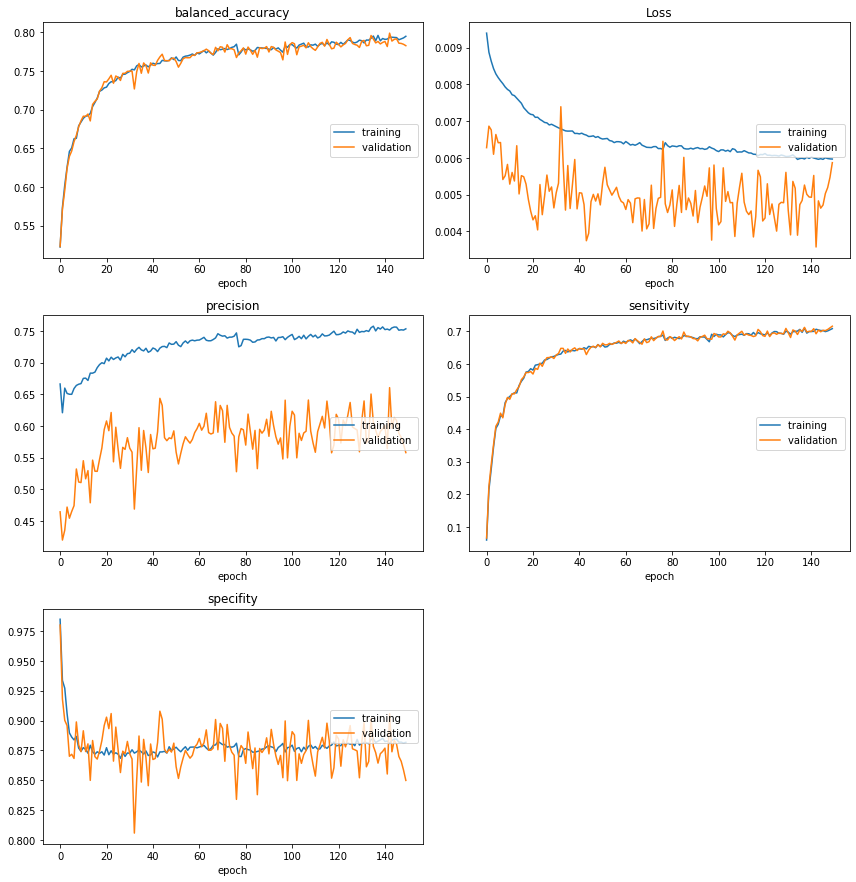

balanced_accuracy
	training         	 (min:    0.509, max:    0.796, cur:    0.795)
	validation       	 (min:    0.501, max:    0.799, cur:    0.783)
Loss
	training         	 (min:    0.006, max:    0.009, cur:    0.006)
	validation       	 (min:    0.004, max:    0.007, cur:    0.006)
precision
	training         	 (min:    0.590, max:    0.757, cur:    0.753)
	validation       	 (min:    0.221, max:    0.660, cur:    0.558)
sensitivity
	training         	 (min:    0.026, max:    0.710, cur:    0.708)
	validation       	 (min:    0.043, max:    0.716, cur:    0.716)
specifity
	training         	 (min:    0.857, max:    0.992, cur:    0.882)
	validation       	 (min:    0.806, max:    0.980, cur:    0.850)
Finished Training


C:\Users\Jonathan\Miniconda3\envs\ojos_ai\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FallLSTMLoop. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [123]:
liveloss = PlotLosses()
model = FallLSTMLoop()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCELoss()
best_model = None
best_metrics = None

mlflow.set_experiment(experiment_name)  # CRITICAL TO CHANGE EVERY TIME
with mlflow.start_run(run_name=datetime.now().strftime("%Y-%m-%d %H:%M:%S")):
    mlflow.log_param('epochs', NUM_EPOCHS)
    mlflow.log_param('features', FEATURES)  
    for epoch in range(NUM_EPOCHS):
        logs = defaultdict(float)
        metrics = defaultdict(int)
        for phase in ['train', 'validation']:
            prefix = 'val_' if phase == 'validation' else ''
            if phase == 'train':
                model.train()
            else:
                model.eval()

            for inputs, labels in dataloaders[phase]:

                outputs = model(inputs.permute(1, 0, 2))
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                logs[f'{prefix}loss'] += loss.item()
                predictions = np.where(outputs > 0.5, 1, 0)
                (tn, fp), (fn, tp) = confusion_matrix(labels, predictions, labels=[0,1])
                metrics['tn'] += tn
                metrics['tp'] += tp
                metrics['fn'] += fn
                metrics['fp'] += fp
            
            logs[f'{prefix}loss'] /= len(dataloaders[phase].dataset)
            logs[f'{prefix}sensitivity'] = metrics['tp'] / (metrics['tp'] + metrics['fn'])
            logs[f'{prefix}specifity'] = metrics['tn'] / (metrics['tn'] + metrics['fp'])
            logs[f'{prefix}precision'] = metrics['tp'] / (metrics['tp'] + metrics['fp'])
            logs[f'{prefix}balanced_accuracy'] = (logs[f'{prefix}sensitivity'] + logs[f'{prefix}specifity']) / 2
            
            if not best_metrics:
                best_model = copy.deepcopy(model)
                best_metrics = copy.deepcopy(logs)
            elif logs['balanced_accuracy'] > best_metrics['balanced_accuracy']:
                best_model = copy.deepcopy(model)
                best_metrics = copy.deepcopy(logs)
            
        liveloss.update(logs)
        liveloss.send()

    mlflow.log_metrics(best_metrics)
    mlflow.pytorch.log_model(best_model, "models")
print('Finished Training')

## Conclusions

OK Folks, That's good enough for now!  
Time to go back to the beginning, read some papers, and try to train a better model, with better input features!  
_Hasta luego!_